## ICRI Envirosensor Data Analysis

#### Download dependencies

In [142]:
#Import json
import json

#Import ijson to read large json files iteratively
import ijson

#Import Time module
import time

import numpy as np
import pandas as pd

#Import matplotlib for plotting graphs
import matplotlib
import matplotlib.pyplot as plt

#Import seaborn to to enhance visualisation
import seaborn as sns

#Import Apache Spark
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql import functions

from pyspark import SparkContext

#Import relevant data types from pyspark schema definition
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

#### Identify data location

In [2]:
from os import path

#In windows the 'r' preceding the file name string indcates that it is a raw sting so that slashes are interpreted correctly
#filename = path.expanduser(r'data\iotp_kfb22t_envirosensor_2018-w19.json')

#Test file
filename = path.expanduser(r'data\Envirosensor_TEST.json')

#Check that the name has been assigned to the variable correctly
print(filename)

data\iotp_kfb22t_envirosensor_2018-w19.json


#### Check file size in KB to ensure it can be loaded into memory

In [3]:
path.getsize(filename) / (1<<10)

48006.8427734375

## Parse JSON

#### Parse JSON data iteratively with ijson

In [4]:
#Define function to iteratively parse json file
def iterativeParse(json):
    with open(json, 'r') as json_file:
        #Use the items method in ijson to extract a list of objects specifying the file and key path to to the list
        objects = ijson.items(json_file, 'item.data')
        #The items fuction returns a generator which we turn into a list of payloads with the list function 
        parsedData = list(objects)

    return parsedData

#Time execution of the iterativeParse function and assign the result to payloads variable
start = time.time()
payloads = iterativeParse(filename)
end = time.time()

#Display time taken to complete process
print(f'\nTime to complete: {end - start:.2f}s\n')

#Count items in the payloads list
print('Total Sensor Payloads =', len(payloads), '\n')

#Check the first item in the payloads list
print('Example Sensor Payload:\n')
print(payloads[0])


Time to complete: 8.49s

Total Sensor Payloads = 98024 

Example Sensor Payload:

{ "DeviceID": "8015", "DeviceType": "Envirosensor", "Event": "event", "Time": "2018-05-11 20:53:39.181958", "Data": { "OPT": "4.57", "TMP": "34.437", "BAT": "34.76", "HDT": "34.62", "BAR": "1012.27", "HDH": "10.01" } }


## Apache Spark

#### Setup Apache Spark

In [95]:
#Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Envirosensor Data Analysis") \
    .getOrCreate()

SparkContext.setSystemProperty('spark.executor.memory', '4g')

In [6]:
#Check Spark 
spark

## Parse JSON Directly into Spark Dataframe

#### Read JSON data directly into Apache Spark data frame

In [7]:
#Place JSON into a Spark dataframe and time execution
start = time.time()
df = spark.read.json(filename, multiLine=True)
end = time.time()

print(f'\nTime to complete: {end - start:.2f}s\n')


Time to complete: 1.85s



#### Display the dataframe

In [8]:
# Display the content of the DataFrame
df.show(5)

+--------------------+--------+------------+---------+------+--------------------+--------------------+
|                data|deviceId|  deviceType|eventType|format|    json_featuretype|           timestamp|
+--------------------+--------+------------+---------+------+--------------------+--------------------+
|{ "DeviceID": "80...|    8015|Envirosensor|    event|  json|iotp_kfb22t_envir...|2018-05-11T20:53:...|
|{ "DeviceID": "80...|    8008|Envirosensor|    event|  json|iotp_kfb22t_envir...|2018-05-12T11:34:...|
|{ "DeviceID": "80...|    8004|Envirosensor|    event|  json|iotp_kfb22t_envir...|2018-05-10T20:04:...|
|{ "DeviceID": "80...|    8007|Envirosensor|    event|  json|iotp_kfb22t_envir...|2018-05-11T19:06:...|
|{ "DeviceID": "80...|    8015|Envirosensor|    event|  json|iotp_kfb22t_envir...|2018-05-11T10:16:...|
+--------------------+--------+------------+---------+------+--------------------+--------------------+
only showing top 5 rows



## Spark Resilient Distributed Datasets (RDD's)

#### Establish sensor data payload schema by loading a sample into a data frame

In [9]:
print(payloads[0:1])

#Time execution of loading payloads into RDD's
start = time.time()
sc = spark.sparkContext
testRDD = sc.parallelize(payloads[0:1],8)
end = time.time()

print(f'\nTime to complete: {end - start:.2f}s\n')

test_df = spark.read.json(testRDD)

test_df.show(5, False)

test_df.printSchema()
test_df.schema

['{ "DeviceID": "8015", "DeviceType": "Envirosensor", "Event": "event", "Time": "2018-05-11 20:53:39.181958", "Data": { "OPT": "4.57", "TMP": "34.437", "BAT": "34.76", "HDT": "34.62", "BAR": "1012.27", "HDH": "10.01" } }']

Time to complete: 0.01s

+--------------------------------------------+--------+------------+-----+--------------------------+
|Data                                        |DeviceID|DeviceType  |Event|Time                      |
+--------------------------------------------+--------+------------+-----+--------------------------+
|[1012.27, 34.76, 10.01, 34.62, 4.57, 34.437]|8015    |Envirosensor|event|2018-05-11 20:53:39.181958|
+--------------------------------------------+--------+------------+-----+--------------------------+

root
 |-- Data: struct (nullable = true)
 |    |-- BAR: string (nullable = true)
 |    |-- BAT: string (nullable = true)
 |    |-- HDH: string (nullable = true)
 |    |-- HDT: string (nullable = true)
 |    |-- OPT: string (nullable = true)

StructType(List(StructField(Data,StructType(List(StructField(BAR,StringType,true),StructField(BAT,StringType,true),StructField(HDH,StringType,true),StructField(HDT,StringType,true),StructField(OPT,StringType,true),StructField(TMP,StringType,true))),true),StructField(DeviceID,StringType,true),StructField(DeviceType,StringType,true),StructField(Event,StringType,true),StructField(Time,StringType,true)))

#### Build and store the data schema

In [10]:
#Build and return a schema to use for the sample data
def build_schema():
    
    schema = test_df.schema
    
    return schema

#### Load payloads into RDD's

In [11]:
#Time execution of loading payloads into RDD's
start = time.time()
sc = spark.sparkContext
payloadsRDD = sc.parallelize(payloads,8)
end = time.time()

print(f'\nTime to complete: {end - start:.2f}s\n')


Time to complete: 0.07s



#### Convert RDD to dataframe using data schema

In [12]:
processedData = spark.read.json(payloadsRDD, schema=build_schema())

#### Display the Spark Dataframe

In [13]:
processedData.show(5,False)

+---------------------------------------------+--------+------------+-----+--------------------------+
|Data                                         |DeviceID|DeviceType  |Event|Time                      |
+---------------------------------------------+--------+------------+-----+--------------------------+
|[1012.27, 34.76, 10.01, 34.62, 4.57, 34.437] |8015    |Envirosensor|event|2018-05-11 20:53:39.181958|
|[1011.63, 34.77, 15.80, 34.33, 6.25, 34.093] |8008    |Envirosensor|event|2018-05-12 11:34:07.296419|
|[1016.71, 35.05, 6.09, 34.90, 6.67, 34.781]  |8004    |Envirosensor|event|2018-05-10 20:04:43.869317|
|[1012.87, 36.69, 5.81, 36.63, 224.48, 36.468]|8007    |Envirosensor|event|2018-05-11 19:06:16.760284|
|[1016.55, 34.13, 10.78, 33.99, 9.16, 33.781] |8015    |Envirosensor|event|2018-05-11 10:16:34.037201|
+---------------------------------------------+--------+------------+-----+--------------------------+
only showing top 5 rows



In [14]:
processedData.count() 

98024

In [15]:
start = time.time()
flat_df = processedData.select("DeviceType", "DeviceID", "Event", "Time", "Data.BAR", "Data.BAT", "Data.HDH", "Data.HDT", "Data.OPT", "Data.TMP")
#flat_df.show(5,False)
end = time.time()

print(f'\nTime to complete: {end - start:.2f}s\n')


Time to complete: 0.04s



In [16]:
flat_df.count()

98024

In [17]:
flat_df.printSchema()
flat_df.schema

root
 |-- DeviceType: string (nullable = true)
 |-- DeviceID: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- BAR: string (nullable = true)
 |-- BAT: string (nullable = true)
 |-- HDH: string (nullable = true)
 |-- HDT: string (nullable = true)
 |-- OPT: string (nullable = true)
 |-- TMP: string (nullable = true)



StructType(List(StructField(DeviceType,StringType,true),StructField(DeviceID,StringType,true),StructField(Event,StringType,true),StructField(Time,StringType,true),StructField(BAR,StringType,true),StructField(BAT,StringType,true),StructField(HDH,StringType,true),StructField(HDT,StringType,true),StructField(OPT,StringType,true),StructField(TMP,StringType,true)))

## Display Summary Statistics

In [18]:
flat_df.describe('DeviceType', 'DeviceID', 'Event', 'Time').show()
flat_df.describe('BAR', 'BAT', 'HDH', 'HDT', 'OPT', 'TMP').show()

+-------+------------+-----------------+-----+--------------------+
|summary|  DeviceType|         DeviceID|Event|                Time|
+-------+------------+-----------------+-----+--------------------+
|  count|       98024|            98024|98024|               98024|
|   mean|        null|8009.819840039174| null|                null|
| stddev|        null|5.618286811938404| null|                null|
|    min|Envirosensor|             8001|event|2018-05-10 00:09:...|
|    max|Envirosensor|             8019|event|2018-05-13 23:59:...|
+-------+------------+-----------------+-----+--------------------+

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|               BAR|               BAT|               HDH|               HDT|              OPT|               TMP|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|         

#### Count of Sensor Observations per Device

In [93]:
flat_df.sort('DeviceID').groupBy('DeviceID').count().show()

+--------+-----+
|DeviceID|count|
+--------+-----+
|    8001| 5749|
|    8002| 5748|
|    8003| 5276|
|    8004| 5747|
|    8005| 5745|
|    8006| 5749|
|    8007| 5748|
|    8008| 5748|
|    8010| 5750|
|    8011| 5745|
|    8012| 5749|
|    8013| 5273|
|    8014| 4801|
|    8015| 5745|
|    8016| 2446|
|    8017| 5513|
|    8018| 5746|
|    8019| 5746|
+--------+-----+



## Summary by Device

#### Filter results by Device

In [19]:
sensor_df = flat_df.filter(flat_df["DeviceID"]=="8001")

#### Display summary for sensor

In [20]:
sensor_df.describe('DeviceType', 'DeviceID', 'Event', 'Time').show()
sensor_df.describe('BAR', 'BAT', 'HDH', 'HDT', 'OPT', 'TMP').show()

+-------+------------+--------------------+-----+--------------------+
|summary|  DeviceType|            DeviceID|Event|                Time|
+-------+------------+--------------------+-----+--------------------+
|  count|        5749|                5749| 5749|                5749|
|   mean|        null|              8001.0| null|                null|
| stddev|        null|2.276108937398238...| null|                null|
|    min|Envirosensor|                8001|event|2018-05-10 00:09:...|
|    max|Envirosensor|                8001|event|2018-05-13 23:59:...|
+-------+------------+--------------------+-----+--------------------+

+-------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|               BAR|               BAT|               HDH|               HDT|               OPT|                TMP|
+-------+------------------+------------------+------------------+------------------+------------------+------

#### Display sorted sensor readings

In [21]:
sensor_df.sort('Time').show(10,False)

+------------+--------+-----+--------------------------+-------+-----+-----+-----+----+------+
|DeviceType  |DeviceID|Event|Time                      |BAR    |BAT  |HDH  |HDT  |OPT |TMP   |
+------------+--------+-----+--------------------------+-------+-----+-----+-----+----+------+
|Envirosensor|8001    |event|2018-05-10 00:09:17.997009|1007.56|35.32|16.01|34.95|2.41|34.750|
|Envirosensor|8001    |event|2018-05-10 00:10:17.998182|1007.52|35.31|16.01|34.95|0.64|34.750|
|Envirosensor|8001    |event|2018-05-10 00:11:18.007436|1007.56|35.31|16.01|34.95|0.64|34.750|
|Envirosensor|8001    |event|2018-05-10 00:12:18.056274|1007.49|35.30|16.01|34.95|1.68|34.750|
|Envirosensor|8001    |event|2018-05-10 00:13:18.055641|1007.52|35.31|16.01|34.97|2.41|34.750|
|Envirosensor|8001    |event|2018-05-10 00:14:18.060749|1007.52|35.32|16.01|34.97|2.41|34.750|
|Envirosensor|8001    |event|2018-05-10 00:15:18.059554|1007.55|35.31|16.01|34.97|0.64|34.750|
|Envirosensor|8001    |event|2018-05-10 00:16:18.0

## Spark SQL Analysis

#### Create temporary view of sensor reading

In [98]:
flat_df.createOrReplaceTempView("sensorReadings")

#### Create a dataframe for that view

In [99]:
df_sql = spark.sql("SELECT * FROM sensorReadings LIMIT 10")

#### Show dataframe

In [101]:
df_sql.show(10, False)

+------------+--------+-----+--------------------------+-------+-----+-----+-----+------+------+
|DeviceType  |DeviceID|Event|Time                      |BAR    |BAT  |HDH  |HDT  |OPT   |TMP   |
+------------+--------+-----+--------------------------+-------+-----+-----+-----+------+------+
|Envirosensor|8015    |event|2018-05-11 20:53:39.181958|1012.27|34.76|10.01|34.62|4.57  |34.437|
|Envirosensor|8008    |event|2018-05-12 11:34:07.296419|1011.63|34.77|15.80|34.33|6.25  |34.093|
|Envirosensor|8004    |event|2018-05-10 20:04:43.869317|1016.71|35.05|6.09 |34.90|6.67  |34.781|
|Envirosensor|8007    |event|2018-05-11 19:06:16.760284|1012.87|36.69|5.81 |36.63|224.48|36.468|
|Envirosensor|8015    |event|2018-05-11 10:16:34.037201|1016.55|34.13|10.78|33.99|9.16  |33.781|
|Envirosensor|8017    |event|2018-05-12 10:29:41.851239|1012.51|33.26|18.01|33.01|7.84  |32.812|
|Envirosensor|8005    |event|2018-05-13 11:40:05.670075|1014.26|34.43|14.91|34.09|124.48|33.843|
|Envirosensor|8010    |event|2

#### Count of Sensor Observations per Device

In [134]:
df_sql = spark.sql("SELECT DeviceID, COUNT(*) AS count FROM sensorReadings GROUP BY DeviceID ORDER BY DeviceID")
df_sql.show()

+--------+-----+
|DeviceID|count|
+--------+-----+
|    8001| 5749|
|    8002| 5748|
|    8003| 5276|
|    8004| 5747|
|    8005| 5745|
|    8006| 5749|
|    8007| 5748|
|    8008| 5748|
|    8010| 5750|
|    8011| 5745|
|    8012| 5749|
|    8013| 5273|
|    8014| 4801|
|    8015| 5745|
|    8016| 2446|
|    8017| 5513|
|    8018| 5746|
|    8019| 5746|
+--------+-----+



#### Convert to Pandas dataframe for visualisation

In [206]:
visual_df = df_sql.toPandas()
visual_df

,DeviceID,count
0,8001,5749
1,8002,5748
2,8003,5276
3,8004,5747
4,8005,5745
5,8006,5749
6,8007,5748
7,8008,5748
8,8010,5750
9,8011,5745


## Plot Count of Sensor Observations

#### Plot data with matplotlib

Text(0.5, 1.0, 'Number of Sensor Observations by Sensor')

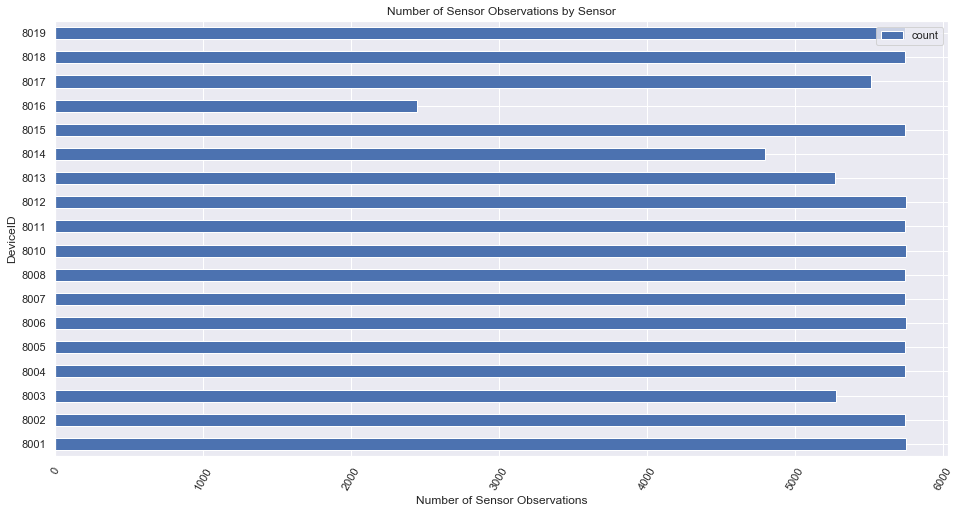

In [336]:
# Use %matplotlib for output plots to appear inline in the Jupyter notebook
%matplotlib inline

# Set the default figure size for all inline plots (must be used after %matplotlib)
plt.rcParams['figure.figsize'] = [16, 8]

# Plot horizontal bar chart
visual_df.plot(kind='barh',x='DeviceID', y='count')
plt.xticks(rotation=60)
plt.ylabel("DeviceID")
plt.xlabel("Number of Sensor Observations")
plt.title("Number of Sensor Observations by Sensor")

#### Plot data with Pandas

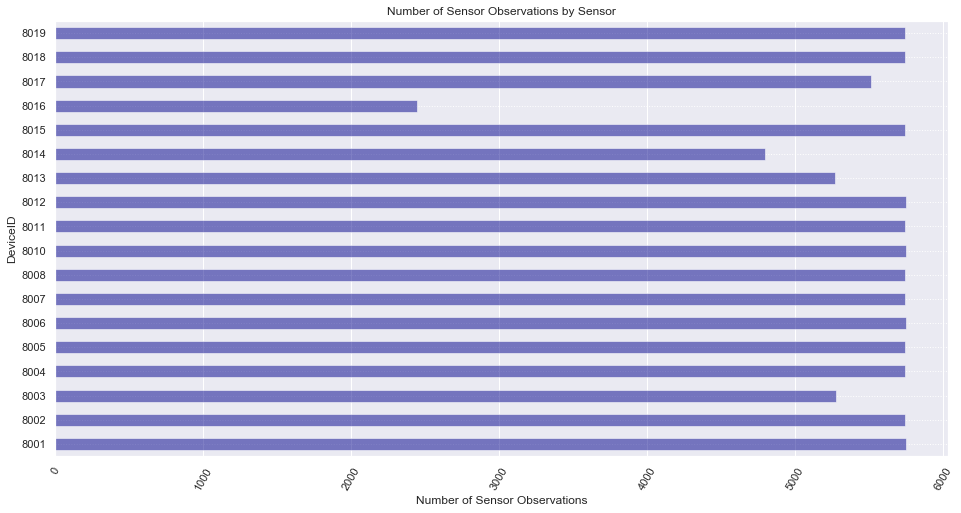

In [340]:
# Plotting directly from DataFrames with Pandas
visual_df.plot(
    x='DeviceID', 
    y='count', 
    kind='barh', 
    legend=False, 
    color='darkblue',
    width=0.5,
    alpha=0.5
)
# The plot is now created, and we use Matplotlib style
# commands to enhance the output.
plt.xticks(rotation=60)
plt.ylabel("DeviceID")
plt.xlabel("Number of Sensor Observations")
plt.title("Number of Sensor Observations by Sensor")
plt.gca().yaxis.grid(linestyle=':')

#### Plot data with Seaborn

Text(0.5, 1.0, 'Number of Sensor Observations by Sensor')

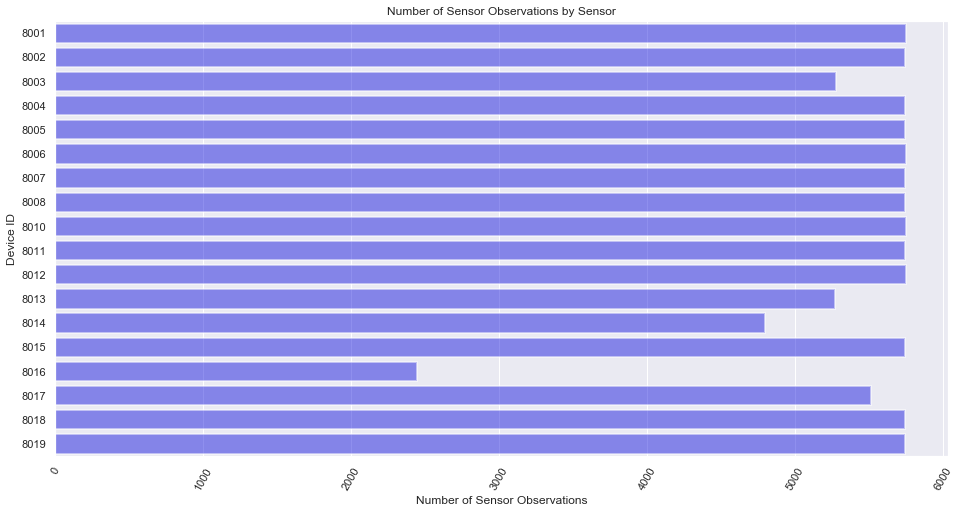

In [343]:
#Set aesthetic parameters
sns.set()

sns.barplot(
    x='count',
    y='DeviceID',
    orient='h',
    color='blue',
    alpha=0.5,
    data=visual_df,
    linewidth=2
)

plt.xticks(rotation=60)
plt.ylabel("Device ID")
plt.xlabel("Number of Sensor Observations")
plt.title("Number of Sensor Observations by Sensor")